<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ConvNeXT/Fine_tune_ConvNeXT_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune ConvNeXT for image classification

This notebook was created as part of [this YouTube video](https://youtu.be/Hn1IgPY42Bw).

It illustrates how to fine-tune [ConvNeXT](https://huggingface.co/docs/transformers/model_doc/convnext), a state-of-the-art image classifier by Meta AI, on a custom dataset (in this case, the [EuroSAT](https://github.com/phelber/EuroSAT) dataset).

## Set-up environment

In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 3.8 MB 7.5 MB/s 
     |████████████████████████████████| 325 kB 70.1 MB/s 
     |████████████████████████████████| 6.5 MB 52.4 MB/s 
     |████████████████████████████████| 895 kB 56.1 MB/s 
     |████████████████████████████████| 596 kB 76.4 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 136 kB 67.0 MB/s 
     |████████████████████████████████| 212 kB 75.5 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
     |████████████████████████████████| 271 kB 76.1 MB/s 
     |████████████████████████████████| 144 kB 75.7 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

## Load dataset

In [ ]:
from datasets import load_dataset

# we can load a custom dataset using the "imagefolder" feature
# details: https://huggingface.co/docs/datasets/image_process#imagefolder
dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

Using custom data configuration default-0537267e6f812d56


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-0537267e6f812d56/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

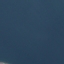

In [ ]:
example = dataset["train"][0]
example["image"]

In [ ]:
example["label"]

9

In [ ]:
labels = dataset["train"].features["label"].names
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [ ]:
id2label[3]

'Highway'

## Push dataset to the hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# dataset.push_to_hub("nielsr/eurosat-demo")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("nielsr/eurosat-demo")

Using custom data configuration nielsr--eurosat-demo-6d87f7d839540879


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/nielsr--eurosat-demo-6d87f7d839540879/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

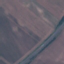

In [ ]:
dataset["train"][0]["image"]

## Process data

In [ ]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [ ]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



In [ ]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose(
    [
     RandomResizedCrop(feature_extractor.size),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]

  return examples

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [ ]:
processed_dataset = dataset.with_transform(train_transforms)

In [ ]:
processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 224, 224])

## Define model

In [ ]:
len(labels)

10

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/109M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Move model to GPU

In [ ]:
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [ ]:
processed_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FBC1A9610D0>,
 'label': 3,
 'pixel_values': tensor([[[-0.4226, -0.4226, -0.4226,  ..., -0.0972, -0.0972, -0.0972],
          [-0.4226, -0.4226, -0.4226,  ..., -0.0972, -0.0972, -0.0972],
          [-0.4226, -0.4226, -0.4226,  ..., -0.0972, -0.0972, -0.0972],
          ...,
          [-0.4397, -0.4397, -0.4397,  ..., -0.4397, -0.4397, -0.4397],
          [-0.4397, -0.4397, -0.4397,  ..., -0.4397, -0.4397, -0.4397],
          [-0.4397, -0.4397, -0.4397,  ..., -0.4397, -0.4397, -0.4397]],
 
         [[-0.3375, -0.3375, -0.3375,  ..., -0.2500, -0.2500, -0.2500],
          [-0.3375, -0.3375, -0.3375,  ..., -0.2500, -0.2500, -0.2500],
          [-0.3375, -0.3375, -0.3375,  ..., -0.2500, -0.2500, -0.2500],
          ...,
          [-0.3725, -0.3725, -0.3725,  ..., -0.4251, -0.4251, -0.4251],
          [-0.3725, -0.3725, -0.3725,  ..., -0.4251, -0.4251, -0.4251],
          [-0.3725, -0.3725, -0.3725,  ..., -0.4251, -0

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=4, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Train the model

In [ ]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(10):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])
    
    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

Epoch: 0


  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.4167359471321106
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.13225021958351135
Accuracy after 100 steps: 0.7475247524752475
Loss after 200 steps: 0.8036932945251465
Accuracy after 200 steps: 0.7810945273631841
Loss after 300 steps: 0.45057225227355957
Accuracy after 300 steps: 0.8006644518272426
Loss after 400 steps: 0.1012667715549469
Accuracy after 400 steps: 0.8273067331670823
Loss after 500 steps: 0.46452900767326355
Accuracy after 500 steps: 0.8318363273453094
Loss after 600 steps: 0.03731042519211769
Accuracy after 600 steps: 0.8456738768718802
Loss after 700 steps: 0.04938995838165283
Accuracy after 700 steps: 0.854493580599144
Loss after 800 steps: 0.10590918362140656
Accuracy after 800 steps: 0.8579900124843945
Loss after 900 steps: 0.2545892298221588
Accuracy after 900 steps: 0.8607103218645948
Loss after 1000 steps: 0.6428396105766296
Accuracy after 1000 steps: 0.8638861138861139
Loss after 1100 steps: 0.39346641302108765
Accuracy after 1100 ste

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.011292369104921818
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.8961852788925171
Accuracy after 100 steps: 0.9504950495049505
Loss after 200 steps: 0.010702572762966156
Accuracy after 200 steps: 0.9514925373134329
Loss after 300 steps: 0.028890706598758698
Accuracy after 300 steps: 0.9559800664451827
Loss after 400 steps: 0.006878295447677374
Accuracy after 400 steps: 0.9544887780548629
Loss after 500 steps: 0.2631339132785797
Accuracy after 500 steps: 0.9510978043912176
Loss after 600 steps: 0.0273672454059124
Accuracy after 600 steps: 0.9504991680532446
Loss after 700 steps: 0.027624839916825294
Accuracy after 700 steps: 0.9514978601997147
Loss after 800 steps: 0.008612778037786484
Accuracy after 800 steps: 0.947565543071161
Loss after 900 steps: 0.5497620105743408
Accuracy after 900 steps: 0.9481132075471698
Loss after 1000 steps: 0.1383814960718155
Accuracy after 1000 steps: 0.9488011988011988
Loss after 1100 steps: 0.012798572890460491
Accuracy after 1

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.06185512617230415
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.21208643913269043
Accuracy after 100 steps: 0.9381188118811881
Loss after 200 steps: 0.005471528507769108
Accuracy after 200 steps: 0.9539800995024875
Loss after 300 steps: 0.00843565072864294
Accuracy after 300 steps: 0.9551495016611296
Loss after 400 steps: 0.1232781782746315
Accuracy after 400 steps: 0.9501246882793017
Loss after 500 steps: 0.12490581721067429
Accuracy after 500 steps: 0.9525948103792415
Loss after 600 steps: 0.030166970565915108
Accuracy after 600 steps: 0.949667221297837
Loss after 700 steps: 0.0404777005314827
Accuracy after 700 steps: 0.9522111269614836
Loss after 800 steps: 0.005521424114704132
Accuracy after 800 steps: 0.9531835205992509
Loss after 900 steps: 0.007269063964486122
Accuracy after 900 steps: 0.9544950055493896
Loss after 1000 steps: 0.20961472392082214
Accuracy after 1000 steps: 0.9530469530469531
Loss after 1100 steps: 0.018100377172231674
Accuracy after 

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.005073942709714174
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.8119612336158752
Accuracy after 100 steps: 0.9504950495049505
Loss after 200 steps: 0.17842139303684235
Accuracy after 200 steps: 0.9527363184079602
Loss after 300 steps: 0.8503753542900085
Accuracy after 300 steps: 0.9485049833887044
Loss after 400 steps: 0.02778717316687107
Accuracy after 400 steps: 0.9526184538653366
Loss after 500 steps: 0.08483904600143433
Accuracy after 500 steps: 0.9515968063872255
Loss after 600 steps: 0.0012745677959173918
Accuracy after 600 steps: 0.9517470881863561
Loss after 700 steps: 0.005641628056764603
Accuracy after 700 steps: 0.9550641940085592
Loss after 800 steps: 0.6319754719734192
Accuracy after 800 steps: 0.9572409488139825
Loss after 900 steps: 0.003944942727684975
Accuracy after 900 steps: 0.9583795782463929
Loss after 1000 steps: 0.004290894139558077
Accuracy after 1000 steps: 0.957042957042957
Loss after 1100 steps: 0.033528104424476624
Accuracy after

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.0021274955943226814
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.007741900160908699
Accuracy after 100 steps: 0.9801980198019802
Loss after 200 steps: 0.07838080823421478
Accuracy after 200 steps: 0.9776119402985075
Loss after 300 steps: 0.01564148999750614
Accuracy after 300 steps: 0.9775747508305648
Loss after 400 steps: 0.0014632679522037506
Accuracy after 400 steps: 0.9788029925187033
Loss after 500 steps: 0.0035212223883718252
Accuracy after 500 steps: 0.9780439121756487
Loss after 600 steps: 0.05187685787677765
Accuracy after 600 steps: 0.9771214642262895
Loss after 700 steps: 0.015866845846176147
Accuracy after 700 steps: 0.9753922967189729
Loss after 800 steps: 0.006255805026739836
Accuracy after 800 steps: 0.9734706616729089
Loss after 900 steps: 0.0009403584408573806
Accuracy after 900 steps: 0.9716981132075472
Loss after 1000 steps: 0.11906805634498596
Accuracy after 1000 steps: 0.9712787212787213
Loss after 1100 steps: 0.012334824539721012
Accur

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.32941898703575134
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.0010939016938209534
Accuracy after 100 steps: 0.9579207920792079
Loss after 200 steps: 1.818398356437683
Accuracy after 200 steps: 0.9614427860696517
Loss after 300 steps: 0.002042206237092614
Accuracy after 300 steps: 0.9667774086378738
Loss after 400 steps: 0.010556340217590332
Accuracy after 400 steps: 0.9694513715710723
Loss after 500 steps: 0.003962830174714327
Accuracy after 500 steps: 0.968562874251497
Loss after 600 steps: 0.050440236926078796
Accuracy after 600 steps: 0.968801996672213
Loss after 700 steps: 0.001331370323896408
Accuracy after 700 steps: 0.9679029957203994
Loss after 800 steps: 0.11828165501356125
Accuracy after 800 steps: 0.9691011235955056
Loss after 900 steps: 0.0006547746015712619
Accuracy after 900 steps: 0.9689234184239733
Loss after 1000 steps: 0.329766184091568
Accuracy after 1000 steps: 0.9662837162837162
Loss after 1100 steps: 0.35716283321380615
Accuracy afte

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.0013678036630153656
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.02029513008892536
Accuracy after 100 steps: 0.9554455445544554
Loss after 200 steps: 0.005568472668528557
Accuracy after 200 steps: 0.9664179104477612
Loss after 300 steps: 0.010533750057220459
Accuracy after 300 steps: 0.9634551495016611
Loss after 400 steps: 0.1162056028842926
Accuracy after 400 steps: 0.9619700748129676
Loss after 500 steps: 0.007850774563848972
Accuracy after 500 steps: 0.9635728542914171
Loss after 600 steps: 0.015390565618872643
Accuracy after 600 steps: 0.9654742096505824
Loss after 700 steps: 0.07195491343736649
Accuracy after 700 steps: 0.9668330955777461
Loss after 800 steps: 0.377245157957077
Accuracy after 800 steps: 0.966916354556804
Loss after 900 steps: 0.000585822737775743
Accuracy after 900 steps: 0.9664261931187569
Loss after 1000 steps: 0.7812296152114868
Accuracy after 1000 steps: 0.9665334665334665
Loss after 1100 steps: 0.3075970709323883
Accuracy after 1

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.00754961185157299
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0387725867331028
Accuracy after 100 steps: 0.9455445544554455
Loss after 200 steps: 0.010568711906671524
Accuracy after 200 steps: 0.9614427860696517
Loss after 300 steps: 0.043083176016807556
Accuracy after 300 steps: 0.9642857142857143
Loss after 400 steps: 0.0018155360594391823
Accuracy after 400 steps: 0.9650872817955112
Loss after 500 steps: 0.00019235290528740734
Accuracy after 500 steps: 0.967564870259481
Loss after 600 steps: 0.008265075273811817
Accuracy after 600 steps: 0.968801996672213
Loss after 700 steps: 0.005011674948036671
Accuracy after 700 steps: 0.9693295292439372
Loss after 800 steps: 0.0008131247595883906
Accuracy after 800 steps: 0.9684769038701623
Loss after 900 steps: 0.0032318662852048874
Accuracy after 900 steps: 0.9680910099889012
Loss after 1000 steps: 0.11108507961034775
Accuracy after 1000 steps: 0.9682817182817183
Loss after 1100 steps: 0.007502023596316576
Accura

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.1582196056842804
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.008916087448596954
Accuracy after 100 steps: 0.9678217821782178
Loss after 200 steps: 0.05386865884065628
Accuracy after 200 steps: 0.9601990049751243
Loss after 300 steps: 0.5348714590072632
Accuracy after 300 steps: 0.9667774086378738
Loss after 400 steps: 0.0025995709002017975
Accuracy after 400 steps: 0.9713216957605985
Loss after 500 steps: 0.002155557507649064
Accuracy after 500 steps: 0.9725548902195609
Loss after 600 steps: 0.007117483299225569
Accuracy after 600 steps: 0.9733777038269551
Loss after 700 steps: 0.013213475234806538
Accuracy after 700 steps: 0.9721825962910129
Loss after 800 steps: 0.006017250008881092
Accuracy after 800 steps: 0.9725343320848939
Loss after 900 steps: 0.015225857496261597
Accuracy after 900 steps: 0.9716981132075472
Loss after 1000 steps: 0.0017429892905056477
Accuracy after 1000 steps: 0.9725274725274725
Loss after 1100 steps: 0.0321476049721241
Accuracy a

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps: 0.04875260218977928
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.057947788387537
Accuracy after 100 steps: 0.9653465346534653
Loss after 200 steps: 0.01978490501642227
Accuracy after 200 steps: 0.9751243781094527
Loss after 300 steps: 0.0004037608450744301
Accuracy after 300 steps: 0.9700996677740864
Loss after 400 steps: 0.0010733880335465074
Accuracy after 400 steps: 0.9713216957605985
Loss after 500 steps: 0.000641913153231144
Accuracy after 500 steps: 0.9715568862275449
Loss after 600 steps: 0.002180470386520028
Accuracy after 600 steps: 0.9737936772046589
Loss after 700 steps: 0.00413261353969574
Accuracy after 700 steps: 0.9732524964336662
Loss after 800 steps: 0.0607028603553772
Accuracy after 800 steps: 0.9731585518102372
Loss after 900 steps: 0.022293390706181526
Accuracy after 900 steps: 0.9739178690344062
Loss after 1000 steps: 0.0023417682386934757
Accuracy after 1000 steps: 0.9735264735264735
Loss after 1100 steps: 0.017473218962550163
Accuracy a

## Push it to the hub

In [ ]:
repo_name = "nielsr/convnext-tiny-finetuned-eurosat"

model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/106M [00:00<?, ?B/s]

To https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat
   73b78e0..7a2e6c0  main -> main

To https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat
   7a2e6c0..4f3580e  main -> main



'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat/commit/4f3580e91046d22e9917fd94a2a36e23314e80fd'

## Inference

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")
model = AutoModelForImageClassification.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")

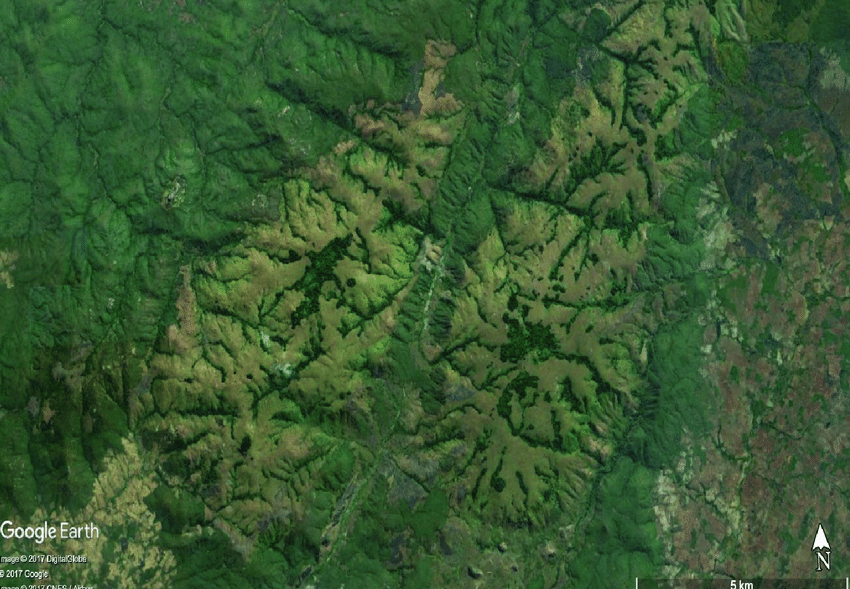

In [ ]:
from PIL import Image
import requests

url = "https://www.researchgate.net/profile/Sam-Jones-35/publication/320710912/figure/fig11/AS:667901359050755@1536251501500/Google-earth-satellite-imagery-of-the-Njesi-Plateau-showing-dark-green-forest-patches.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
pixel_values = feature_extractor(image.convert("RGB"), return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [ ]:
print(logits.shape)

torch.Size([1, 10])


In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

Forest


## Pipeline API

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor)

In [ ]:
pipe(image)

[{'label': 'Forest', 'score': 0.9989117383956909},
 {'label': 'HerbaceousVegetation', 'score': 0.0005626519559882581},
 {'label': 'Pasture', 'score': 0.00034275249345228076},
 {'label': 'AnnualCrop', 'score': 5.9258782130200416e-05},
 {'label': 'SeaLake', 'score': 4.3437339627416804e-05}]